# Исследование данных о российском кинопрокате



**Заказчик исследования** — Министерство культуры Российской Федерации. 

**Цель исслевования** - проанализировать российский рынок кинопроката и определить актуальные тенденции. 


Для анализа будем использовать данные, представленные на портале открытых данных Министерства культуры. Этот набор данных содержит информацию о прокатных удостоверениях, сборах и государственной поддержке фильмов, а также данные с сайта КиноПоиск.
Обратим особое внимание на фильмы, которые получили государственную поддержку. Вясним, насколько эти фильмы интересны зрителям.

## 1. Обзор данных

#### Описание данных
Таблица `mkrf_movies` содержит информацию из реестра прокатных удостоверений. У одного фильма может быть несколько прокатных удостоверений. 
- `title` — название фильма;
- `puNumber` — номер прокатного удостоверения;
- `show_start_date` — дата премьеры фильма;
- `type` — тип фильма;
- `film_studio` — студия-производитель;
- `production_country` — страна-производитель;
- `director` — режиссёр;
- `producer` — продюсер;
- `age_restriction` — возрастная категория;
- `refundable_support` — объём возвратных средств государственной поддержки;
- `nonrefundable_support` — объём невозвратных средств государственной поддержки;
- `financing_source` — источник государственного финансирования;
- `budget` — общий бюджет фильма;
- `ratings` — рейтинг фильма на КиноПоиске;
- `genres` — жанр фильма.

Cтолбец `budget` уже включает в себя полный объём государственной поддержки. Данные в этом столбце указаны только для тех фильмов, которые получили государственную поддержку. 

Таблица `mkrf_shows` содержит сведения о показах фильмов в российских кинотеатрах.
- `puNumber` — номер прокатного удостоверения;
- `box_office` — сборы в рублях.

#### Объединение данных в один датафрейм

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
from matplotlib.ticker import MultipleLocator

In [2]:
mkrf_movies = pd.read_csv('mkrf_movies.csv')
mkrf_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7486 entries, 0 to 7485
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  7486 non-null   object 
 1   puNumber               7486 non-null   object 
 2   show_start_date        7486 non-null   object 
 3   type                   7486 non-null   object 
 4   film_studio            7468 non-null   object 
 5   production_country     7484 non-null   object 
 6   director               7477 non-null   object 
 7   producer               6918 non-null   object 
 8   age_restriction        7486 non-null   object 
 9   refundable_support     332 non-null    float64
 10  nonrefundable_support  332 non-null    float64
 11  budget                 332 non-null    float64
 12  financing_source       332 non-null    object 
 13  ratings                6519 non-null   object 
 14  genres                 6510 non-null   object 
dtypes: f

In [3]:
mkrf_movies.head(3)

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres
0,Открытый простор,221048915,2015-11-27T12:00:00.000Z,Художественный,"Тачстоун Пикчерз, Кобальт Пикчерз, Бикон Пикче...",США,Кевин Костнер,"Дэвид Валдес, Кевин Костнер, Джейк Эбертс",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,7.2,"боевик,драма,мелодрама"
1,Особо важное задание,111013716,2016-09-13T12:00:00.000Z,Художественный,"Киностудия ""Мосфильм""",СССР,Е.Матвеев,NaN,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,6.6,"драма,военный"
2,Особо опасен,221038416,2016-10-10T12:00:00.000Z,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер"


In [4]:
mkrf_shows = pd.read_csv('mkrf_shows.csv')
mkrf_shows.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3158 entries, 0 to 3157
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   puNumber    3158 non-null   int64  
 1   box_office  3158 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 49.5 KB


In [5]:
mkrf_shows.head(3)

,puNumber,box_office
0,111000113,2450.0
1,111000115,61040.0
2,111000116,153030013.4


В датасете присутствуют очень большие числа, которые неудобно читать. Исправим эту проблему, поменяв формат их вывода.

In [6]:
# Зададим формат вывода больших чисел
pd.options.display.float_format = '{:20,.2f}'.format

Исходя из общей информации о датафреймах, объединять данные будем по номеру прокатного удостоверения `puNumber`. Для этого необходимо привести значения `puNumber` в датафрейме `mkrf_movies` к целочисленному типу.

In [7]:
# mkrf_movies['puNumber'] = mkrf_movies['puNumber'].astype(int)
# ValueError: invalid literal for int() with base 10: 'нет'

Из текста ошибки видно, что среди значений `puNumber` есть одно нечисловое - это строка `'нет'`, поэтому воспользуемся другим способом приведения к целочисленному типу, где строка `'нет'` заменится на пустое значение `NA`.

In [8]:
mkrf_movies['puNumber'] = pd.to_numeric(mkrf_movies['puNumber'], errors='coerce').fillna(pd.NA).astype('Int64')
mkrf_movies['puNumber'].dtypes  # проверяем результат

Int64Dtype()

In [9]:
# Для совместимости при объединении датасетов используем такой же способ приведения для датасета mkrf_shows 
mkrf_shows['puNumber'] = mkrf_shows['puNumber'].astype('Int64')
mkrf_shows['puNumber'].dtypes

Int64Dtype()

In [10]:
# Объединим датасеты по столбцу puNumber
mkrf_movies_shows = mkrf_movies.merge(mkrf_shows, on='puNumber', how='left')
mkrf_movies_shows.head(3)

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
0,Открытый простор,221048915,2015-11-27T12:00:00.000Z,Художественный,"Тачстоун Пикчерз, Кобальт Пикчерз, Бикон Пикче...",США,Кевин Костнер,"Дэвид Валдес, Кевин Костнер, Джейк Эбертс",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,7.2,"боевик,драма,мелодрама",NaN
1,Особо важное задание,111013716,2016-09-13T12:00:00.000Z,Художественный,"Киностудия ""Мосфильм""",СССР,Е.Матвеев,NaN,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,6.6,"драма,военный",NaN
2,Особо опасен,221038416,2016-10-10T12:00:00.000Z,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер",NaN


In [11]:
mkrf_movies_shows.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7486 entries, 0 to 7485
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  7486 non-null   object 
 1   puNumber               7485 non-null   Int64  
 2   show_start_date        7486 non-null   object 
 3   type                   7486 non-null   object 
 4   film_studio            7468 non-null   object 
 5   production_country     7484 non-null   object 
 6   director               7477 non-null   object 
 7   producer               6918 non-null   object 
 8   age_restriction        7486 non-null   object 
 9   refundable_support     332 non-null    float64
 10  nonrefundable_support  332 non-null    float64
 11  budget                 332 non-null    float64
 12  financing_source       332 non-null    object 
 13  ratings                6519 non-null   object 
 14  genres                 6510 non-null   object 
 15  box_

Из информации, выведенной методом `info()`, видно, что все 7486 строк из основного датасета `mkrf_movies` вошли в получившийся датафрейм `mkrf_movies_shows` - общее количество строк у обоих датасетов совпадает. Для этого мы специально использовали объединение с типом `left`.

#### Приведение названия столбцов к единому стилю

In [12]:
# Переименуем столбец puNumber
mkrf_movies_shows = mkrf_movies_shows.rename(columns={'puNumber': 'pu_number'})
mkrf_movies_shows.columns

Index(['title', 'pu_number', 'show_start_date', 'type', 'film_studio',
       'production_country', 'director', 'producer', 'age_restriction',
       'refundable_support', 'nonrefundable_support', 'budget',
       'financing_source', 'ratings', 'genres', 'box_office'],
      dtype='object')

#### Вывод

Из общей информации об объединенном датасете можно сделать следующие выводы:
1. Все данные из основного датасета `mkrf_movies были` сохранены при объединении с датасетом `mkrf_shows`
2. В данных присутствуют пропуски, которые будем обрабатывать на этапе предобработки.
2. Привели некорректные названия столбцов к единому стилю.
3. Необходимо будет изменить тип данных в некторых столбцах - сделаем это на этапе предобработки.

## 2. Предобработка данных

### 2.1 Изменение типов данных

Столбцы с некорректным типом данных
- `show_start_date` — дата премьеры фильма
- `ratings` — рейтинг фильма на КиноПоиске

In [13]:
# Изменим тип данных для даты премьеры фильма
mkrf_movies_shows['show_start_date'] = pd.to_datetime(mkrf_movies_shows['show_start_date'])
mkrf_movies_shows['show_start_date'].dtypes # провери результат
mkrf_movies_shows['show_start_date'].head()

0   2015-11-27 12:00:00+00:00
1   2016-09-13 12:00:00+00:00
2   2016-10-10 12:00:00+00:00
3   2016-06-10 12:00:00+00:00
4   2015-07-29 12:00:00+00:00
Name: show_start_date, dtype: datetime64[ns, UTC]

In [14]:
# Просмотрим уникальные значения столбца c рейтингом фильма на КиноПоиске
mkrf_movies_shows['ratings'].unique()

array(['7.2', '6.6', '6.8', '7.7', '8.3', '8.0', '7.8', '8.1', '7.1',
       '6.0', '7.4', '5.8', '8.7', '6.3', '6.9', '5.0', '4.3', '7.3',
       '7.0', '6.4', nan, '8.2', '7.5', '6.7', '7.9', '5.9', '6.2', '5.6',
       '6.5', '2.4', '7.6', '6.1', '8.6', '8.5', '8.8', '5.5', '5.1',
       '5.7', '5.4', '99%', '4.4', '4.5', '5.3', '4.1', '8.4', '2.6',
       '3.8', '4.6', '4.8', '4.0', '3.0', '1.6', '4.2', '5.2', '4.7',
       '4.9', '3.9', '2.7', '3.3', '2.9', '28%', '3.7', '1.4', '3.1',
       '97%', '3.5', '3.2', '2.8', '1.5', '2.1', '2.5', '9.2', '3.4',
       '1.1', '3.6', '83%', '64%', '91%', '94%', '62%', '79%', '90%',
       '19%', '88%', '1.0', '89%', '1.3', '1.9', '1.8', '1.2', '1.7',
       '9.0', '98%', '8.9', '9.1'], dtype=object)

В столбце объединены рейтинг фильмы (числа с точкой) и рейтинг ожиданий фильма, который еще не вышел в прокат (целые числа с процентами). 

Значения с процентом не соответствуют границам допустимых значений рейтинга 0-10. Это явная ошибка, возможно подгруженная из другого источника. Поэтому сделаем пустыми такие значения.

In [15]:
# Заменим в столбце с рейтингом все значения с процентами на пустые значения
mkrf_movies_shows['ratings'] = mkrf_movies_shows['ratings'].replace(r'\d\d%', np.nan, regex=True)

In [16]:
# Проверим еще раз уникальные значения столбца
mkrf_movies_shows['ratings'].unique()

array(['7.2', '6.6', '6.8', '7.7', '8.3', '8.0', '7.8', '8.1', '7.1',
       '6.0', '7.4', '5.8', '8.7', '6.3', '6.9', '5.0', '4.3', '7.3',
       '7.0', '6.4', nan, '8.2', '7.5', '6.7', '7.9', '5.9', '6.2', '5.6',
       '6.5', '2.4', '7.6', '6.1', '8.6', '8.5', '8.8', '5.5', '5.1',
       '5.7', '5.4', '4.4', '4.5', '5.3', '4.1', '8.4', '2.6', '3.8',
       '4.6', '4.8', '4.0', '3.0', '1.6', '4.2', '5.2', '4.7', '4.9',
       '3.9', '2.7', '3.3', '2.9', '3.7', '1.4', '3.1', '3.5', '3.2',
       '2.8', '1.5', '2.1', '2.5', '9.2', '3.4', '1.1', '3.6', '1.0',
       '1.3', '1.9', '1.8', '1.2', '1.7', '9.0', '8.9', '9.1'],
      dtype=object)

In [17]:
# Скорректируем тип данных
mkrf_movies_shows['ratings'] = mkrf_movies_shows['ratings'].astype(float)
mkrf_movies_shows['ratings'].dtypes # проверяем результат

dtype('float64')

##### Вывод

- Преобразовали колонку `show_start_date` в дату
- Очистили от ошибочных значений колонку `ratings` и привели ее к типу Float

### 2.2 Удаление пропусков

In [18]:
# Создаем копию датасета до преобразования
temp = mkrf_movies_shows.copy() 
len(temp)

7486

In [19]:
# Вычислим контрольный размер датасета до преобразования
len(mkrf_movies_shows)

7486

In [20]:
# Выведем количество пропущенных значений для каждого столбца
mkrf_movies_shows.isna().sum()

title                       0
pu_number                   1
show_start_date             0
type                        0
film_studio                18
production_country          2
director                    9
producer                  568
age_restriction             0
refundable_support       7154
nonrefundable_support    7154
budget                   7154
financing_source         7154
ratings                   996
genres                    976
box_office               4328
dtype: int64

**Столбцы с пропусками**

Столбцы c пропусками с текстовым типом данных поменяем на заглушку `Unknown`, т.к. восстановить такие значения не представляется возможным:
- film_studio — студия-производитель
- production_country — страна-производитель
- director — режиссёр
- producer — продюсер
- genres — жанр фильма

В следующих столбцах оставим пропуски как есть, т.к. не все фильмы имеют государственную поддержку:
- refundable_support — объём возвратных средств государственной поддержки
- nonrefundable_support — объём невозвратных средств государственной поддержки
- financing_source — источник государственного финансирования
- budget — общий бюджет фильма

Столбцы, где пропуски возможны из-за отсутствия информации и логичную замену предложить невозможно, оставляем пропуски как есть:
- ratings — рейтинг фильма на КиноПоиске
- box_office — сборы в рублях

In [21]:
# Заменяем пропуски в признаке студия-производитель на Unknown
mkrf_movies_shows['film_studio'] = mkrf_movies_shows['film_studio'].fillna('Unknown')
mkrf_movies_shows['film_studio'].isna().sum()  # проверяем наличие пропусков

0

In [22]:
# Заменяем пропуски в признаке страна-производитель на Unknown
mkrf_movies_shows['production_country'] = mkrf_movies_shows['production_country'].fillna('Unknown')
mkrf_movies_shows['production_country'].isna().sum()  # проверяем наличие пропусков

0

In [23]:
# Заменяем пропуски в признаке режиссёр на Unknown
mkrf_movies_shows['director'] = mkrf_movies_shows['director'].fillna('Unknown')
mkrf_movies_shows['director'].isna().sum()  # проверяем наличие пропусков

0

In [24]:
# Заменяем пропуски в признаке жанр фильма на Unknown
mkrf_movies_shows['producer'] = mkrf_movies_shows['producer'].fillna('Unknown')
mkrf_movies_shows['producer'].isna().sum()  # проверяем наличие пропусков

0

In [25]:
# Заменяем пропуски в признаке продюсер на Unknown
mkrf_movies_shows['genres'] = mkrf_movies_shows['genres'].fillna('Unknown')
mkrf_movies_shows['genres'].isna().sum()  # проверяем наличие пропусков

0

In [26]:
# Вычислим контрольный размер датасета после преобразования
len(mkrf_movies_shows)

7486

##### Вывод

1. Заменили пропуски на заглушку `Unknown` в столбцах: `film_studio`, `production_country`, `director`, `producer`, `genres`.
2. В остальных столбцах оставили пропуски как есть, так как логичную замену предложить невозможно.

### 2.3 Обработка дубликатов

#### 2.3.1 Полные дубликаты

In [27]:
# Проверим наличие полных дубликатов, т.е. дубликатов по всем столбцам одновременно
mkrf_movies_shows.duplicated().sum()

0

Полные дубликаты отсутствуют

#### 2.3.2 Дубликаты номера прокатного удостоверения

In [28]:
# Проверим наличие одинаковых номеров прокатного удостоверения
mkrf_movies_shows['pu_number'].duplicated().sum()             

2

In [29]:
# Выведем строки с задублированным номером прокатного удостоверения
mkrf_movies_shows[mkrf_movies_shows['pu_number'].duplicated()]

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
4639,Иоанна - женщина на папском престоле /По роман...,221154310,2010-12-17 12:00:00+00:00,Художественный,"Константин Фильм, А Эр Ди Дегето Фильм, Дюне ...",Германия - Великобритания - Италия - Испания,Зенке Вортманн,"Оливер Бербен, Дорис Д.Хайнце, Фарук Элтан",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,7.60,"драма,мелодрама,история",NaN
5068,Анализируй то!,221054410,2010-05-25 12:00:00+00:00,Художественный,"Уорнер Бразерс, Виллидж Роадшоу Пикчерз, Эн-Пи...",США,Гарольд Реймис,"Джейн Розенталь, Паул Уэйнстейн",«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,6.80,"комедия,криминал",NaN


In [30]:
# Выведем все строки с задублированным номером прокатного удостоверения
mkrf_movies_shows[mkrf_movies_shows['pu_number'].isin([221154310, 221054410])]

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
4638,Как жениться и остаться холостым,221154310,2010-12-17 12:00:00+00:00,Художественный,"Ше Вам, Скрипт Ассосье, Тэ Фэ 1 Фильм Продюксь...",Франция,Эрик Лартиго,"Амандин Било, Алан Шаба",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,7.00,"мелодрама,комедия",NaN
4639,Иоанна - женщина на папском престоле /По роман...,221154310,2010-12-17 12:00:00+00:00,Художественный,"Константин Фильм, А Эр Ди Дегето Фильм, Дюне ...",Германия - Великобритания - Италия - Испания,Зенке Вортманн,"Оливер Бербен, Дорис Д.Хайнце, Фарук Элтан",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,7.60,"драма,мелодрама,история",NaN
5067,Анализируй это!,221054410,2010-05-25 12:00:00+00:00,Художественный,"Уорнер Бразерс, Вилладж Роудшоу Филмз ЛТД",США-Австралия,ХЭрольд Рэмис,"Джейн Розенталь, Пола Уейнстейн",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,7.40,"комедия,криминал",NaN
5068,Анализируй то!,221054410,2010-05-25 12:00:00+00:00,Художественный,"Уорнер Бразерс, Виллидж Роадшоу Пикчерз, Эн-Пи...",США,Гарольд Реймис,"Джейн Розенталь, Паул Уэйнстейн",«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,6.80,"комедия,криминал",NaN


По выведенным данным видно, что это разные фильмы, которым по ошибке присвоили одинаковые номера прокатного удостоверения. 

На сайте https://culture.gov.ru найдем правильные номера:
- Анализируй то! - 221147210, поменяем на правильный номер прокатного удостоверения
- Анализируй это! - 221054410
- Как жениться и остаться холостым - 121002007, поменяем на правильный номер прокатного удостоверения
- Иоанна - женщина на папском престоле /По роман. - 221154310

In [31]:
# Присвоим правильный номер прокатного удостоверения для фильма "Анализируй то!"
mkrf_movies_shows.loc[
    (mkrf_movies_shows['pu_number'] == 221054410) & (mkrf_movies_shows['title'] == 'Анализируй то!'),
    'pu_number'
] = 221147210                 

In [32]:
# Присвоим правильный номер прокатного удостоверения для фильма "Как жениться и остаться холостым"
mkrf_movies_shows.loc[
    (mkrf_movies_shows['pu_number'] == 221154310) & (mkrf_movies_shows['title'] == 'Как жениться и остаться холостым'),
    'pu_number'
] = 121002007  

In [33]:
# Проверим еще раз остались ли дубликаты в столбце номера прокатного удостоверения
mkrf_movies_shows['pu_number'].duplicated().sum()

0

#### 2.3.3 Неявные дубликаты жанра фильма

In [34]:
mkrf_movies_shows['genres'].value_counts()

genres
Unknown                         976
драма                           476
комедия                         352
мелодрама,комедия               222
драма,мелодрама,комедия         189
                               ... 
мюзикл,фэнтези,семейный           1
мюзикл,мелодрама,фэнтези          1
документальный,новости,драма      1
семейный,детектив,детский         1
мелодрама,история,драма           1
Name: count, Length: 743, dtype: int64

Колонка "Жанры" содержит множественные значения, поэтому без выделения уникальных значений в отдельный справочник искать неявные дубликаты не имеет смысла. 

На шаге 2.6 мы выделим основной (первый) жанр в отдельный столбец и после этого проверим его на неявные дубли.

#### 2.3.4 Неявные дубликаты возрастных ограничений

In [35]:
mkrf_movies_shows['age_restriction'].value_counts()

age_restriction
«16+» - для детей старше 16 лет           2851
«18+» - запрещено для детей               1605
«12+» - для детей старше 12 лет           1593
«0+» - для любой зрительской аудитории     811
«6+» - для детей старше 6 лет              626
Name: count, dtype: int64

Неявные дубликаты в возрастных категориях не обнаружены

#### 2.3.5 Неявные дубликаты страны производства

In [36]:
mkrf_movies_shows['production_country'].value_counts()

production_country
США                                                                    2172
Россия                                                                 1821
СССР                                                                    347
Франция                                                                 301
Великобритания                                                          257
                                                                       ... 
Франция-Китай                                                             1
Россия, Германия, Великобритания                                          1
Великобритания - Италия - Испания                                         1
Россия-Ирландия                                                           1
Дания - Канада - Швеция - Франция - Германия - Великобритания - США       1
Name: count, Length: 951, dtype: int64

Колонка "Страна производства" содержит множественные значения, поэтому без выделения уникальных значений в отдельный справочник искать неявные дубликаты не имеет смысла.

#### 2.3.6 Неявные дубликаты режиссера

In [37]:
mkrf_movies_shows['director'].value_counts()

director
О.Семёнова                  47
Стивен Содерберг            17
Д.Червяцов                  17
Ридли Скотт                 16
Тиль Швайгер                14
                            ..
Том Коркоран                 1
Е.Сергеев                    1
Фернандо Гонзалез Молина     1
Е.Перволовичи                1
И.Трусов                     1
Name: count, Length: 4812, dtype: int64

Колонка "Режиссер" содержит множественные значения, поэтому без выделения уникальных значений в отдельный справочник искать неявные дубликаты не имеет смысла.

#### 2.3.7 Неявные дубликаты типа фильма

In [38]:
mkrf_movies_shows['type'].unique()

array(['Художественный', 'Анимационный', 'Прочие', 'Документальный',
       'Научно-популярный', ' Художественный', ' Анимационный',
       'Музыкально-развлекательный'], dtype=object)

In [39]:
# Исправим выявленные неявные дубли
mkrf_movies_shows['type'] = (mkrf_movies_shows['type'].str    
    .replace(' Художественный', 'Художественный', regex=True)
    .replace(' Анимационный', 'Анимационный', regex=True)
)
mkrf_movies_shows['type'].unique() # проверяем результат

array(['Художественный', 'Анимационный', 'Прочие', 'Документальный',
       'Научно-популярный', 'Музыкально-развлекательный'], dtype=object)

#### 2.3.8 Дубликаты названия фильма

Целесообразность проверки на уникальность по названиям фильма сомнительна, так как одинаковые фильмы могут иметь разные прокатные удостоверения. Удостоверения выдаются отдельно на показ в кинотеатрах, на продажу фильма на носителях, на трансляцию по кабельным сетям и т.д. Поэтому одинаковые фильмы с разными удостоверениями не являются дубликатами.

#### Вывод

На шаге 2.3 мы изучили дубликаты в датафрейме
- полные дубликаты отсутствуют
- обработали дубликаты с номерами прокатного удостоверения.
- присвоили правильные номера прокатных удостоверений для двух фильмов
- неявные дубликаты в возростных категориях не обнаружены
- колонки "Жанры", "Страна производства" и "Режиссер" содержат множественные значения, поэтому без выделения уникальных значений в отдельный справочник искать неявные дубликаты не имеет смысла.
- исправили выявленные неявные дубли в колонке "Тип фильма"
- проверка названия фильма на уникальность нецелесообразна, т.к. одинаковые названия часто встречаются у разных фильмов

### 2.4 Изучение категориальных значений

К основным полям с категориальными значениями можно отнести следующие столбцы:
- `genres` — жанр фильма
- `director` — режиссёр
- `type` — тип фильма

На предыдущем шаге было видно, что в столбцах `genres` и `director` есть общая проблема - они содержат множественные значения в виде списков. Поэтому, для работы с этими полями, на шаге 2.6 мы выделим первые значения списков отдельные столбцы.

Проблема в столбце `type` была в ниличие неявных дублей - на предыдущем шаге мы ее исправили.

### 2.5 Проверка количественных значений

Столбцы, в которых содержатся количественные значения: 
- `budget` — общий бюджет фильма
- `refundable_support` — объём возвратных средств государственной поддержки
- `nonrefundable_support` — объём невозвратных средств государственной поддержки
- `box_office` — сборы в рублях
- `ratings` — рейтинг фильма на КиноПоиске

In [40]:
# Просмотрим общую статистику по всем количественным значениям 
mkrf_movies_shows.describe()

,pu_number,refundable_support,nonrefundable_support,budget,ratings,box_office
count,"7,485.00",332.00,332.00,332.00,"6,490.00","3,158.00"
mean,"135,183,219.56","11,864,457.83","48,980,988.89","127,229,716.68",6.48,"76,478,696.16"
std,"38,340,422.87","24,916,555.26","59,980,117.92","188,588,333.12",1.10,"240,353,122.82"
min,"1,811,096.00",0.00,0.00,0.00,1.00,0.00
25%,"112,025,118.00",0.00,"25,000,000.00","42,000,000.00",5.90,"86,239.00"
50%,"121,015,419.00",0.00,"30,000,000.00","68,649,916.00",6.60,"2,327,987.55"
75%,"124,003,313.00","15,000,000.00","40,375,000.00","141,985,319.50",7.20,"23,979,671.02"
max,"231,001,111.00","180,000,000.00","400,000,000.00","2,305,074,303.00",9.20,"3,073,568,690.79"


#### 2.5.1 Общий бюджет фильма, возвратные и невозвратные средства господдержки

Из общей статистической информации выше видно, что минимальное значение в стоблце `budget` равно нулю - это не нормально.

Рассмотрим эти строки подробнее.

In [41]:
# Посчитаем строки, где бюджет равен нулю 
mkrf_movies_shows.loc[mkrf_movies_shows['budget'] == 0, 'budget'].count()

17

In [42]:
# Так как `budget` тесно связан со значениями из столбцов `refundable_support` и `nonrefundable_support` - 
# выведем только эти три столбца с нулевым бюджетом
mkrf_movies_shows.loc[mkrf_movies_shows['budget'] == 0, ['budget','refundable_support','nonrefundable_support']]

,budget,refundable_support,nonrefundable_support
2053,0.00,0.00,"23,000,000.00"
2058,0.00,0.00,"75,000,000.00"
2472,0.00,"10,000,000.00","70,000,000.00"
2532,0.00,"20,000,000.00",0.00
2615,0.00,"60,000,000.00","100,000,000.00"
2684,0.00,0.00,"59,000,000.00"
2788,0.00,0.00,"35,000,000.00"
2874,0.00,0.00,"6,000,000.00"
3047,0.00,"19,000,000.00","51,000,000.00"
3565,0.00,0.00,"250,000,000.00"


Ситуация проблемная - бюджет нулевой, но при этом указаны значения для возвратных и невозвратных средств государственной поддержки.

Пути решения:
- удалить проблемные строки с нулевым бюджетом - не подходит, т.к. для исследования могут понадобиться значения из других столбцов
- вставить пустые значения в три столбца `budget`, `refundable_support` и `nonrefundable_support`, где бюджет нулевой
- наиболее подходящим считаю решение - не исправлять, но при исследовании, где используются столбцы `budget`, `refundable_support` и `nonrefundable_support`, предварительно отфильтровать строки с нулевым бюджетом

Других подозрительных данных в столбцах `budget`, `refundable_support` и `nonrefundable_support` не обнаружено.

#### 2.5.2 Сборы в рублях

Из общей статистической информации выше видно, что минимальное значение в стоблце Сборы равно нулю, при этом медианное значение ненулевое - это подозрительно.

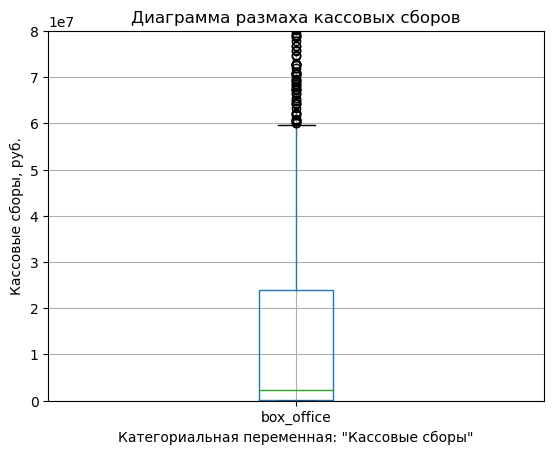

In [43]:
# Выведем диаграмму размаха
mkrf_movies_shows.boxplot(column=['box_office'])
plt.ylim(0, 80000000)
plt.title('Диаграмма размаха кассовых сборов')
plt.ylabel('Кассовые сборы, руб.')
plt.xlabel('Категориальная переменная: "Кассовые сборы"')
plt.show()

In [44]:
# Посчитаем границы нормальных значений
Q1 = mkrf_movies_shows['box_office'].quantile(0.25)  # первый квартиль
Q3 = mkrf_movies_shows['box_office'].quantile(0.75)  # третий квартиль
min_value = mkrf_movies_shows['box_office'].min()    # минимальное значение
max_value = mkrf_movies_shows['box_office'].max()    # максимельное значение

IQR = Q3 - Q1  # межквартильный размах

# левая граница нормальных значений
left = Q1 - 1.5 * IQR
if left > min_value:
    left = left
else:
    left = min_value

# правая граница нормальных значений
right = Q3 + 1.5 * IQR  
if right > max_value:
    right = max_value
else:
    right = right    

print(f"Границы нормальных значений: {left:.2f}, {right:.2f}")

Границы нормальных значений: 0.00, 59819819.06


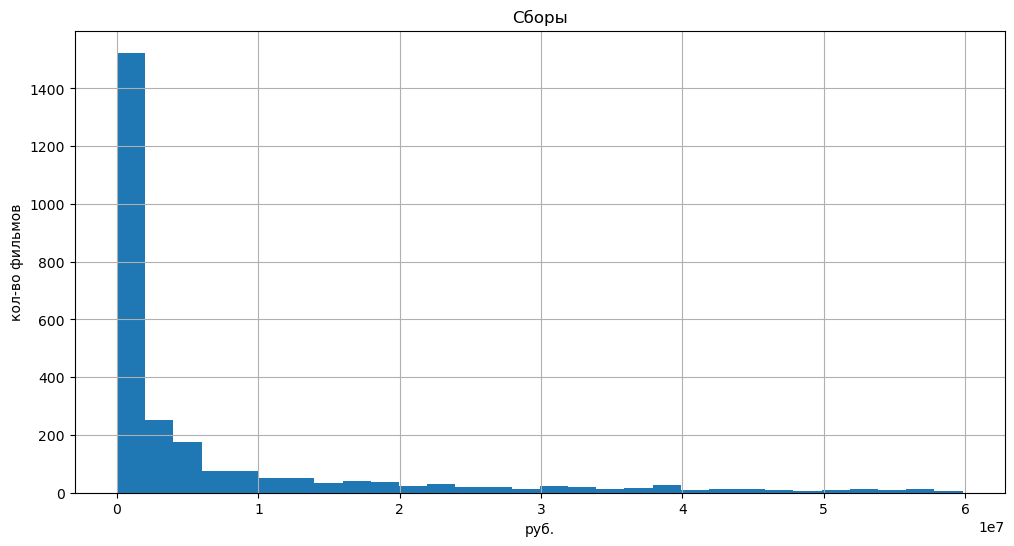

In [45]:
# Выведем гистограмму разброса значений в пределах нормальных значений
mkrf_movies_shows['box_office'].hist(bins=30, range=(left, right), figsize=(12, 6))
plt.title('Сборы')
plt.xlabel('руб.')
plt.ylabel('кол-во фильмов')
plt.show()

На гистограмме видно, что околонулевых значений сбора очень много и это выглядит нереальным.

Возможно, это ошибка при занесении данных - указали в тысячах или миллионах, либо указали сумму в валюте.

#### 2.5.3 Рейтинг фильма на КиноПоиске

Из общей статистической информации выше подозрительных отклонений в данных не видно.

#### Вывод

На шаге 2.5 мы проверили количественные значения:
- В столбце `budget` обнаружена проблемная ситуация - бюджет нулевой, но при этом указаны значения для возвратных и не возвратных средств государственной поддержки. Подходящим считаю решение - не исправлять, но при исследовании, где используются столбцы budget, refundable_support и nonrefundable_support, предварительно отфильтровать строки с нулевым бюджетом.
- `box_office` — сборы в рублях, обнаружены подозрительные данные. Минимальное значение в стоблце Сборы равно нулю, при этом медианное значение ненулевое. На гистограмме видно, что околонулевых значений сбора очень много и это выглядет нереальным. Возможно, что это ошибка при занесении данных - указали в тысячах или миллионах, либо указали сумму в валюте.
- `ratings` — рейтинг фильма на КиноПоиске, подозрительных отклонений в данных не видно.

### 2.6 Добавление новых столбцов

#### 2.6.1 Год проката

In [46]:
# Создадим столбец с информацией о годе проката
mkrf_movies_shows['show_start_year'] = mkrf_movies_shows['show_start_date'].dt.year
mkrf_movies_shows['show_start_year']

0       2015
1       2016
2       2016
3       2016
4       2015
        ... 
7481    2019
7482    2019
7483    2019
7484    2019
7485    2019
Name: show_start_year, Length: 7486, dtype: int32

Создали столбец с информацией о годе проката.

#### 2.6.2 Главный режиссёр

In [47]:
# Выведем на экран список унильных значений режиссера
mkrf_movies_shows['director'].unique()

array(['Кевин Костнер', 'Е.Матвеев', 'Тимур Бекмамбетов', ...,
       'Ник Пауэлл', 'А.Беляев', 'И.Трусов'], dtype=object)

In [48]:
# Создадим функцию, которая выведет первые значения из списка
def get_first_value(values_str):
    result = values_str.split(',')
    return result[0].strip()
    
# Применим функцию get_first_value() методом apply()
mkrf_movies_shows['director_first'] = mkrf_movies_shows['director'].apply(get_first_value)   
print(mkrf_movies_shows['director_first'].head())

0        Кевин Костнер
1            Е.Матвеев
2    Тимур Бекмамбетов
3    Тимур Бекмамбетов
4    Тимур Бекмамбетов
Name: director_first, dtype: object


In [49]:
#mkrf_movies_shows['director_first'].unique()
display(mkrf_movies_shows['director_first'].unique().tolist())

['Кевин Костнер',
 'Е.Матвеев',
 'Тимур Бекмамбетов',
 'В.Абдрашитов',
 'В.Меньшов',
 'Джон Туртурро',
 'Эрик Беснард',
 'В.Титов',
 'Пол Грингросс',
 'М.Туманишвили',
 'Клинт Иствуд',
 'Фернанду Мейрелльеш',
 'Майк Фиггис',
 'А.Салтыков',
 'Г.Данелия',
 'А.Смирнов',
 'Ю.Чулюкин',
 'В.Краснопольский',
 'М.Чиаурели',
 'Лассе Халлстрем',
 'Л.Гайдай',
 'В.Чеботарев',
 'В.Азаров',
 'Боривой Земан',
 'Эндрю Никкол',
 'Г.Мыльников',
 'Джонатан Кинг',
 'И.Бабич',
 'Даниэль Робишо',
 'Грегори Хоблит',
 'Крис Нунан',
 'Стивен Фрирз',
 'Йэн Софтли',
 'Найл Джонсон',
 'Р.Быков',
 'Роб Райнер',
 'Бен Янгер',
 'Роб Маршалл',
 'Е.Ташков',
 'Н.Михалков',
 'Ю.Карасик',
 'А.Тарковский',
 'Джон Франкенхаймер',
 'Оливье Маршал',
 'С.Соловьев',
 'Иоахим Реннинг',
 'Ролан Быков',
 'Семен Туманов',
 'Питер Сигал',
 'М.Ромм',
 'Г.Полока',
 'Ю.Райзман',
 'Дрю Дэйуолт',
 'С.Самсонов',
 'Айрон Блейз',
 'К.Шахназаров',
 'И.Гостев',
 'Т.Лукашевич',
 'В.Павлович',
 'Эмиль Лотяну',
 'Тиль Швайгер',
 'А.Птушко',
 'Г

#### 2.6.3 Основной жанр

In [50]:
# Выведем на экран список унильных значений жанра фильма
mkrf_movies_shows['genres'].unique()

array(['боевик,драма,мелодрама', 'драма,военный',
       'фантастика,боевик,триллер', 'драма', 'мелодрама,комедия',
       'мюзикл,мелодрама,комедия', 'комедия,криминал',
       'боевик,триллер,детектив', 'боевик,драма,приключения',
       'драма,спорт', 'триллер,драма,мелодрама', 'комедия,мелодрама',
       'драма,мелодрама,комедия', 'драма,мелодрама', 'драма,история',
       'драма,мелодрама,семейный', 'комедия,мелодрама,криминал',
       'комедия', 'боевик,драма,криминал', 'драма,комедия',
       'ужасы,фантастика,комедия', 'мультфильм,короткометражка,мелодрама',
       'драма,криминал', 'мультфильм,фантастика,фэнтези',
       'триллер,драма,криминал', 'драма,мелодрама,биография',
       'драма,комедия,военный', 'фантастика,драма,детектив',
       'мюзикл,семейный', 'Unknown', 'военный,приключения,драма',
       'документальный,драма', 'драма,биография,история',
       'боевик,триллер,драма', 'фэнтези,боевик',
       'боевик,комедия,криминал', 'мюзикл,комедия,детский',
       'комед

In [51]:
# Применим функцию get_first_value() методом apply()
mkrf_movies_shows['genres_first'] = mkrf_movies_shows['genres'].apply(get_first_value)   
mkrf_movies_shows['genres_first'].head()

0        боевик
1         драма
2    фантастика
3    фантастика
4    фантастика
Name: genres_first, dtype: object

In [52]:
# Проверим новый столбец на невяные дубли
mkrf_movies_shows['genres_first'].unique()

array(['боевик', 'драма', 'фантастика', 'мелодрама', 'мюзикл', 'комедия',
       'триллер', 'ужасы', 'мультфильм', 'Unknown', 'военный',
       'документальный', 'фэнтези', 'криминал', 'приключения', 'аниме',
       'детектив', 'для взрослых', 'семейный', 'концерт', 'история',
       'короткометражка', 'детский', 'спорт', 'биография', 'вестерн',
       'музыка', 'фильм-нуар', 'реальное ТВ'], dtype=object)

Неявные дубли не обнаружены

#### 2.6.4 Доля господдержки

In [53]:
# Выделим в отдельный датасет информацию о фильмах с господдержкой, т.е. где указан бюджет
non_zero_budget = mkrf_movies_shows.loc[mkrf_movies_shows['budget'] > 0].copy()

# Добавим стобец с долей господдержки
non_zero_budget['support_rate'] = ((non_zero_budget['refundable_support'] + non_zero_budget['nonrefundable_support']) 
                                          / non_zero_budget['budget'])
non_zero_budget.head(3)

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office,show_start_year,director_first,genres_first,support_rate
1281,Пока еще жива,111005313,2013-10-11 12:00:00+00:00,Художественный,"АНО содействия развитию кинематографии ""Ангел-...",Россия,А.Атанесян,"А.Атанесян, М.Бабаханов, Р.Бутко",«16+» - для детей старше 16 лет,0.00,"26,500,000.00","79,411,900.00",Министерство культуры,8.10,"драма,мелодрама","365,353.60",2013,А.Атанесян,драма,0.33
1448,Бесславные придурки,111003314,2014-03-28 12:00:00+00:00,Художественный,"ООО ""Компания ""АТК-Студио""",Россия,А.Якимчук,А.Тютрюмов,«12+» - для детей старше 12 лет,0.00,"26,000,000.00","37,142,857.00",Министерство культуры,NaN,Unknown,"28,140.00",2014,А.Якимчук,Unknown,0.70
1498,Невидимки,111004213,2013-09-10 12:00:00+00:00,Художественный,"ООО ""Компания ""РЕАЛ-ДАКОТА""",Россия,"Р.Давлетьяров, С.Комаров","Р.Давлетьяров, А.Котелевский, А.Олейников",«12+» - для детей старше 12 лет,0.00,"107,847,945.00","176,023,490.00",Фонд кино,5.30,"комедия,фантастика","19,957,031.50",2013,Р.Давлетьяров,комедия,0.61


In [54]:
# Добавим в основной датасет информацию о доле господдержки
mkrf_movies_shows = pd.merge(
    mkrf_movies_shows, 
    non_zero_budget[['pu_number','support_rate']], 
    on='pu_number', 
    how='left'
)
mkrf_movies_shows.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7486 entries, 0 to 7485
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   title                  7486 non-null   object             
 1   pu_number              7485 non-null   Int64              
 2   show_start_date        7486 non-null   datetime64[ns, UTC]
 3   type                   7486 non-null   object             
 4   film_studio            7486 non-null   object             
 5   production_country     7486 non-null   object             
 6   director               7486 non-null   object             
 7   producer               7486 non-null   object             
 8   age_restriction        7486 non-null   object             
 9   refundable_support     332 non-null    float64            
 10  nonrefundable_support  332 non-null    float64            
 11  budget                 332 non-null    float64          

На шаге 2.6 мы добавили 4 новых столбца: год проката, главный режиссер, основной жанр и доля господдержки.

#### **Вывод**

На этапе предобработки данных была проделана следующая работа: 

1. **Проверили типы данных и преобразовали их там, где это было необходимо**: <br>преобразовали колонку `show_start_date` в дату, очистили от ошибочных значений колонку `ratings` и привели ее к типу Float.<br><br>
 
2. **Изучили пропуски в датасете и заменили их там, где это было возможно**:
- заменили пропуски на заглушку `Unknown` в столбцах: `film_studio`, `production_country`, `director`, `producer`, `genres`.
- в остальных столбцах оставили пропуски как есть, так как логичную замену предложить невозможно.

3. **Изучили дубликаты в датафрейме**:
- полные дубликаты отсутствовали
- обработали дубликаты с номерами прокатного удостоверения. 
- присвоили правильные номера прокатных удостоверений для двух фильмов
- неявные дубликаты в возростных категориях не обнаружили
- колонки "Жанры", "Страна производства" и "Режиссер" содержат множественные значения, поэтому без выделения уникальных значений в отдельный справочник искать неявные дубликаты не имело смысла.
- исправили выявленные неявные дубли в колонке "Тип фильма"
- проверка уникальных названий фильмов была нецелесообразна, т.к. названия у разных фильмов могут совпадать

4. **Изучили категориальные значения**: <br>в столбцах `genres` и `director` выявили общую проблему - они содержат множественные значения в виде списков. Поэтому, для работы с этими полями, на шаге 2.6 мы выделили первые значения списков отдельные столбцы.<br><br>

5. **Проверили количественные значения**:
- В столбце `budget` была обнаружена проблемная ситуация - бюджет нулевой, но при этом указаны значения для возвратных и не возвратных средств государственной поддержки. Решила не исправлять, но при исследовании, где используются столбцы 
`budget`, `refundable_support` и `nonrefundable_support`, предварительно буду отфильтровать строки с нулевым бюджетом.
- `box_office` — сборы в рублях, были обнаружены подозрительные данные. Минимальное значение в стоблце Сборы равно нулю, 
при этом медианное значение ненулевое. На гистограмме было видно, что околонулевых значений сбора очень много и это выглядит нереальным. Возможно, это ошибка при занесении данных - указали в тысячах или миллионах, либо указали сумму в валюте.
- `ratings` — рейтинг фильма на КиноПоиске, подозрительных отклонений в данных не увидела.

6. **Создали новые столбцы**:
- `show_start_year` - столбец с информацией о годе проката
- `director_first` - cтолбец с главным режиссером. В столбец вошли первые значения из списка режиссёров.
- `genres_first` - столбец с основным жанром фильма. В столбец вошли первые значения из списка жанров.
 
7. **Посчитали какую долю от общего бюджета фильма составляет государственная поддержка**.
- выделили в отдельный датасет информацию о фильмах с господдержкой, т.е. где указан бюджет. Затем добавили стобец с долей господдержки.
- добавили в основной датасет информацию о доле господдержки

## 3. Исследовательский анализ данных


### 3.1 Сколько фильмов выходило в прокат каждый год

- Посмотрим, сколько фильмов выходило в прокат каждый год. Обратим внимание, что данные о прокате в кинотеатрах известны не для всех фильмов. Посчитаем, какую долю составляют фильмы с указанной информацией о прокате в кинотеатрах. Проанализируем, как эта доля менялась по годам. Сделаем вывод о том, какой период полнее всего представлен в данных.

In [55]:
# Посмотрим сколько фильмов выходило в прокат каждый год и у скольких фильмов указана сумма сборов
show_counts = mkrf_movies_shows.pivot_table(index= 'show_start_year', values=['title', 'box_office'], aggfunc='count').reset_index()
show_counts.columns = ['year', 'box_office_count', 'movies_count']
display(show_counts)

,year,box_office_count,movies_count
0,2010,105,985
1,2011,109,622
2,2012,128,593
3,2013,184,630
4,2014,279,807
5,2015,465,705
6,2016,526,818
7,2017,357,505
8,2018,475,891
9,2019,530,930


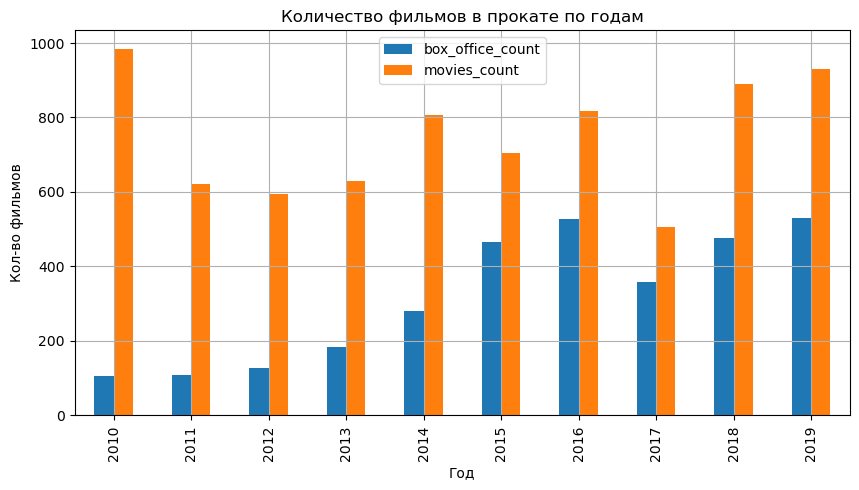

In [56]:
# Посмотрим динамику проката на графике
show_counts.plot(
    x='year', kind='bar', grid = True, figsize=(10, 5),
    title='Количество фильмов в прокате по годам', 
    xlabel='Год',
    ylabel='Кол-во фильмов')
plt.show()

Данные о показах фильмов в российских кинотеатрах (box_office) имеются не во всех строках. Это означает, что часть фильмов выходили в прокат не в кинотеатрах, а, например, на телевидение. Поэтому из полученных данных на графике можно сделать следующие выводы:

- Наибольшее количество фильмов вышло в прокат в 2010 году - 985 фильмов. 
- Меньше всего фильмов вышло в 2017 году - 505 фильмов.
- Количество фильмов с показами в кинотеатрах значительно меньше общего количества фильмов, вышедших в прокат. Но наблюдается тренд роста с единственным просадком в 2017 году. 

In [57]:
# Посчитаем долю фильмов с указанной информацией о прокате в кинотеатрах
show_counts['box_office_percent'] = show_counts['box_office_count'] / show_counts['movies_count']
show_counts

,year,box_office_count,movies_count,box_office_percent
0,2010,105,985,0.11
1,2011,109,622,0.18
2,2012,128,593,0.22
3,2013,184,630,0.29
4,2014,279,807,0.35
5,2015,465,705,0.66
6,2016,526,818,0.64
7,2017,357,505,0.71
8,2018,475,891,0.53
9,2019,530,930,0.57


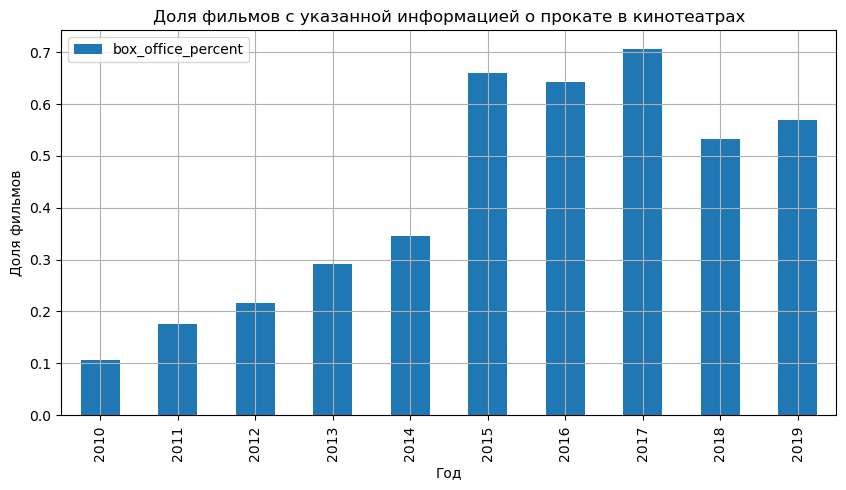

In [58]:
# Посмотрим динамику проката на графике
show_counts.plot(
    x='year', y='box_office_percent', kind='bar', grid = True, figsize=(10, 5),
    title='Доля фильмов с указанной информацией о прокате в кинотеатрах', 
    xlabel='Год',
    ylabel='Доля фильмов')
plt.show()

Доля фильмов с показами в кинотеатрах имеет устойчивый рост с 2010 года (11%) до 2017 года (71%), после чего показатель не опускается ниже 53%.


### 3.2 Сумма сборов по годам

In [59]:
# Изучим как менялась динамика сборов по годам
show_sum = mkrf_movies_shows.pivot_table(index= 'show_start_year', values='box_office', aggfunc='sum').reset_index()
show_sum.columns = ['year', 'box_office_sum']
display(show_sum)

,year,box_office_sum
0,2010,"2,428,654.00"
1,2011,"14,102,765.00"
2,2012,"6,955,423.00"
3,2013,"29,799,706.20"
4,2014,"7,444,951,859.20"
5,2015,"39,497,365,196.40"
6,2016,"47,866,299,741.91"
7,2017,"48,563,707,217.51"
8,2018,"49,668,403,134.32"
9,2019,"48,425,708,779.59"


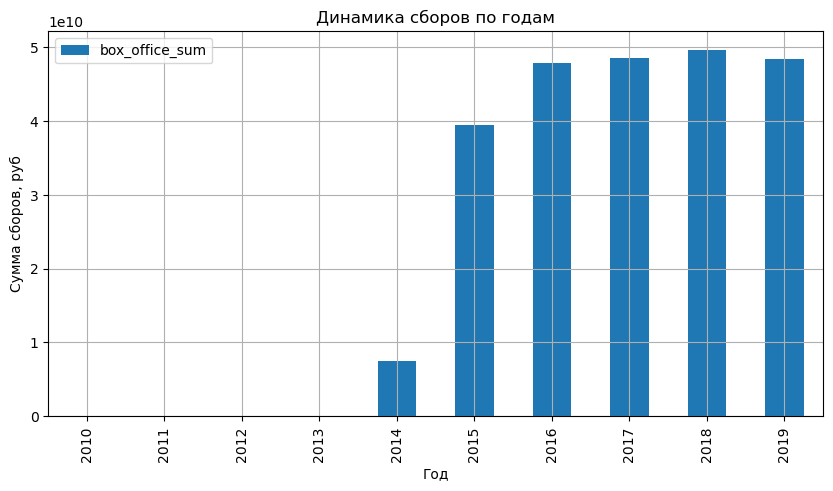

In [60]:
# Посмотрим динамику сборов по годам на графике
show_sum.plot(
    x='year', kind='bar', grid = True, figsize=(10, 5),
    title='Динамика сборов по годам', 
    xlabel='Год',
    ylabel='Сумма сборов, руб')

plt.show()

- По графику видно, что начиная с 2014 по 2019 года наблюдается динамика роста кассовых сборов. 
- Максимальная сумма кассовых сборов была зафиксирована в 2018 году и составила - 49 668 403 134.32 рублей
- Минимальная сумма кассовых сборов была зафиксирована в 2010 году и составила - 2 428 654.00 рублей
- Данных о кассовых сборах за 2010 год очень мало, хотя фильмов в этом году вышло в прокат больше всего (см пункт 3.1).

#### 3.2.1 Средние показатели суммы сборов по годам

- С помощью сводной таблицы посчитаем среднюю и медианную сумму сборов для каждого года.

In [61]:
# Подготовим данные для визуализации - рассчитаем сводную таблицу с медианными и средними значениями 
# сборов в рублях в группе год премьеры
mkrf_movies_shows_pivot = mkrf_movies_shows.pivot_table(
    index= 'show_start_year', values='box_office', aggfunc=['median', 'mean']
).reset_index()
mkrf_movies_shows_pivot.columns = ['year', 'box_office_median', 'box_office_mean']
mkrf_movies_shows_pivot

,year,box_office_median,box_office_mean
0,2010,"1,700.00","23,130.04"
1,2011,"3,000.00","129,383.17"
2,2012,"5,660.00","54,339.24"
3,2013,"3,522.50","161,954.92"
4,2014,"18,160.00","26,684,415.27"
5,2015,"4,920,933.00","84,940,570.31"
6,2016,"3,846,679.41","91,000,569.85"
7,2017,"9,968,340.00","136,032,793.33"
8,2018,"8,891,102.21","104,565,059.23"
9,2019,"4,627,798.34","91,369,261.85"


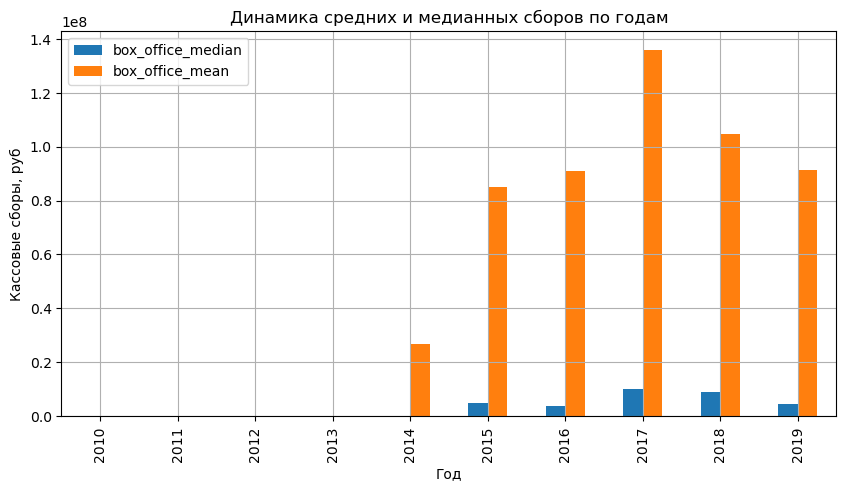

In [62]:
# Построим диаграмму средних и медианных сборов по годам
mkrf_movies_shows_pivot.plot(
    x='year', kind='bar', grid = True, figsize=(10, 5),
    title='Динамика средних и медианных сборов по годам', 
    xlabel='Год',
    ylabel='Кассовые сборы, руб')
plt.show()

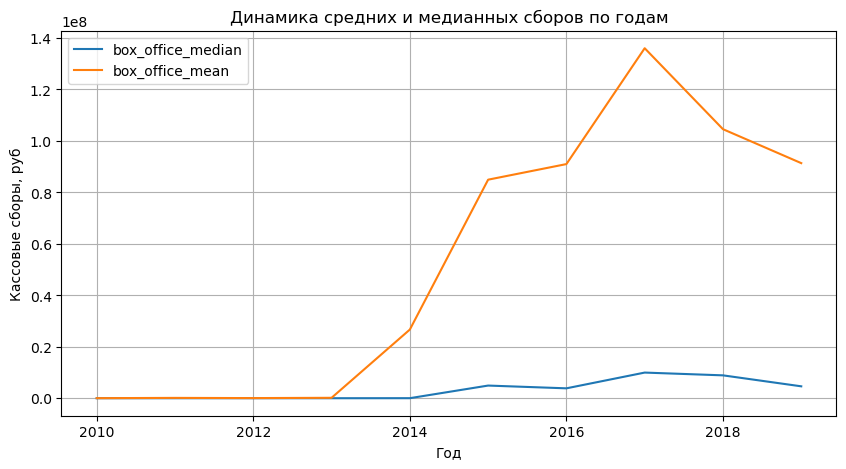

In [63]:
# Построим график динамики средних и медианных сборов по годам
mkrf_movies_shows_pivot.plot(x='year', grid = True, figsize=(10, 5),
    title='Динамика средних и медианных сборов по годам', 
    xlabel='Год',
    ylabel='Кассовые сборы, руб')
plt.show()

- На графике можно увидеть, что средняя по кассовым сборам гораздо больше, чем медиана. Видимо имеются фильмы с большими кассовыми сборами, что оказывает влияние на расчет средней.
- Всплеск средних значений наблюдается в 2017 году

### 3.3 Влияние возрастных ограничений на сборы

In [64]:
# Посмотрим названия возрастных ограничений 
mkrf_movies_shows['age_restriction'].value_counts()

age_restriction
«16+» - для детей старше 16 лет           2851
«18+» - запрещено для детей               1605
«12+» - для детей старше 12 лет           1593
«0+» - для любой зрительской аудитории     811
«6+» - для детей старше 6 лет              626
Name: count, dtype: int64

age_restriction
«0+» - для любой зрительской аудитории         809,077,425.97
«12+» - для детей старше 12 лет             60,619,446,628.33
«16+» - для детей старше 16 лет             76,034,733,643.63
«18+» - запрещено для детей                 40,759,615,572.12
«6+» - для детей старше 6 лет               55,798,610,799.68
Name: box_office, dtype: float64


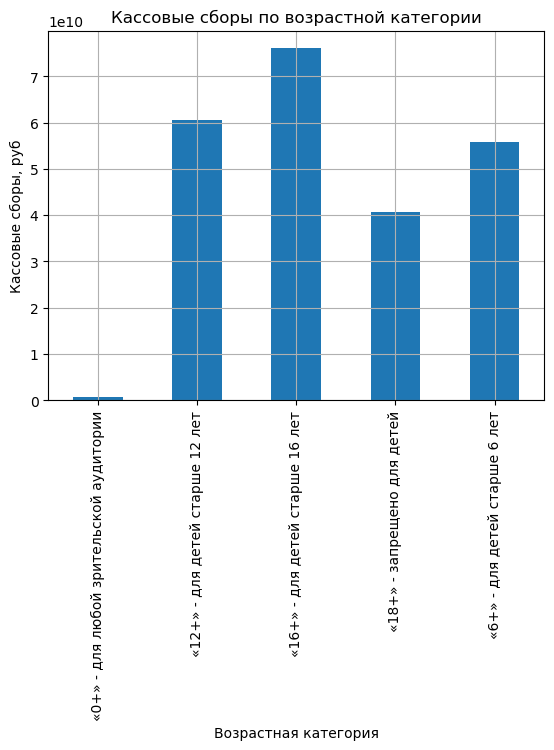

In [65]:
# Выведем общую сумму сборов по каждой возрастной категории
age_restriction_data = mkrf_movies_shows.query('show_start_year >= 2015').groupby('age_restriction')['box_office'].sum()
print(age_restriction_data)
age_restriction_data.plot(kind='bar', grid=True)
plt.title('Кассовые сборы по возрастной категории')
plt.xlabel('Возрастная категория')
plt.ylabel('Кассовые сборы, руб')
plt.show()

- Максимальные кассовые сборы наблюдаются у возрастной категории 16+
- Фильмы с возрастным ограничением 0+ собрали минимальные сборы

In [66]:
# Рассчитаем динамику сборов по каждому возрастному ограничению
age_0_plus = mkrf_movies_shows.query(
    '(show_start_year>=2015) and (age_restriction=="«0+» - для любой зрительской аудитории")'
).groupby('show_start_year')['box_office'].sum()


age_6_plus = mkrf_movies_shows.query(
    '(show_start_year>=2015) and (age_restriction=="«6+» - для детей старше 6 лет")'
).groupby('show_start_year')['box_office'].sum()


age_12_plus = mkrf_movies_shows.query(
    '(show_start_year>=2015) and (age_restriction=="«12+» - для детей старше 12 лет")'
).groupby('show_start_year')['box_office'].sum()


age_16_plus = mkrf_movies_shows.query(
    '(show_start_year>=2015) and (age_restriction=="«16+» - для детей старше 16 лет")'
).groupby('show_start_year')['box_office'].sum()


age_18_plus = mkrf_movies_shows.query(
    '(show_start_year>=2015) and (age_restriction=="«18+» - запрещено для детей")'
).groupby('show_start_year')['box_office'].sum()

age_restrictions_data = pd.concat([age_0_plus, age_6_plus, age_12_plus, age_16_plus, age_18_plus], axis=1).reset_index()
age_restrictions_data.columns = ['year', 'box_office_0+', 'box_office_6+', 'box_office_12+', 'box_office_16+', 'box_office_18+']
age_restrictions_data

,year,box_office_0+,box_office_6+,box_office_12+,box_office_16+,box_office_18+
0,2015,"379,054,578.37","8,701,799,371.41","13,616,082,008.91","11,368,120,870.27","5,432,308,367.44"
1,2016,"150,228,848.67","12,053,146,008.24","12,204,446,524.39","16,664,548,541.74","6,793,929,818.87"
2,2017,"229,598,930.00","12,086,142,145.76","7,851,427,660.67","18,745,042,900.06","9,651,495,581.02"
3,2018,"32,449,002.11","10,104,974,623.41","14,267,291,660.69","16,503,602,346.96","8,760,085,501.15"
4,2019,"17,746,066.82","12,852,548,650.86","12,680,198,773.67","12,753,418,984.60","10,121,796,303.64"


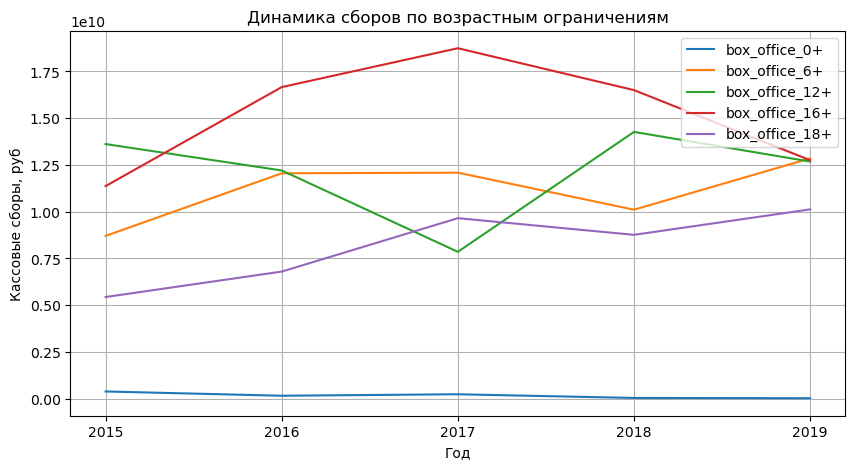

In [67]:
# Построим график динамики сборов по каждому возрастному ограничению
age_restrictions_data.plot(x='year', grid = True, figsize=(10, 5),
    title='Динамика сборов по возрастным ограничениям', 
    xlabel='Год',
    ylabel='Кассовые сборы, руб'
).xaxis.set_major_locator(MultipleLocator(base=1))
plt.show()

- Наименьшие кассовые сборы видны в возрастной категории 0+ в период с 2015 по 2019 года.
- Самые высокие показатели по кассовым сборам наблюдаются у возрастной категории 16+ на протяжении заданного периода.
- По графику видно, что к 2019 году показатели по всем возрастным ограничениям, кроме категории 0+, почти сравнялись. 

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkMagenta'>👉 Можно дополнить анализ диаграммой размаха сборов в прокате по возрастным категориям.</font>

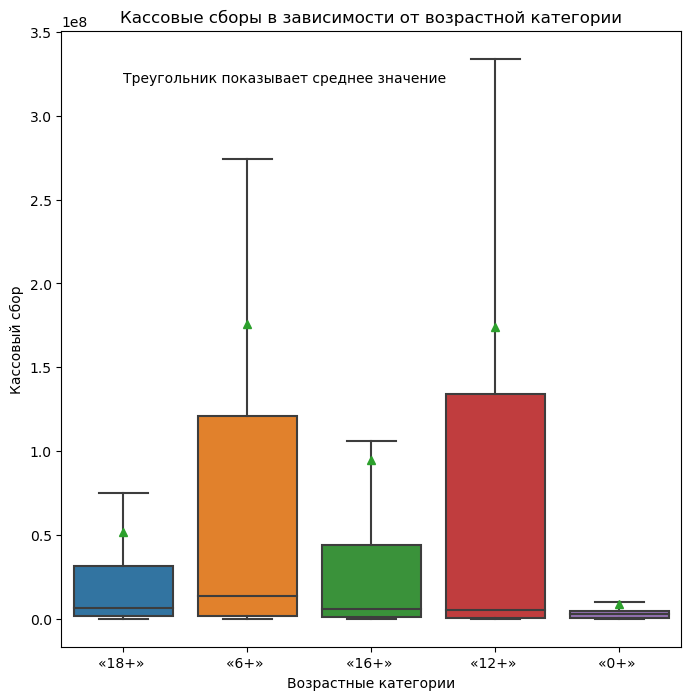

In [68]:
# Комментарий ревьюера 2
import seaborn as sns
temp = mkrf_movies_shows.copy()
# для удобства укоротим названия категорий
def get_first_value(s, sep = ','):  # Функция для выбора первого элемента из перечисления
    value_lst = s.split(sep=sep)
    return value_lst[0]

temp['age_restriction'] = temp['age_restriction'].apply(lambda x: get_first_value(x, sep='-'))
# сохраним маску для среза по годам
year_mask = temp['show_start_year'] >= 2015

plt.figure(figsize=(8, 8))
(sns.boxplot(data = temp.loc[year_mask], y = 'box_office', x='age_restriction', showfliers=False, showmeans=True)
    .set(title = 'Кассовые сборы в зависимости от возрастной категории', 
         xlabel = 'Возрастные категории', ylabel = 'Кассовый сбор'))
plt.text(0, 3.2e8,'Треугольник показывает среднее значение')
plt.show()

<font color='DarkBlue'><b>Комментарий ревьюера 2</b></font><br>
<font color='DarkMagenta'>👉 Для интерпретации диаграмм размаха помогает вспомнить, что означают боксплоты. В данном случае расположение боксплота и медианы показывают у какой возрастной категории стабильно высокие сборы.</font>
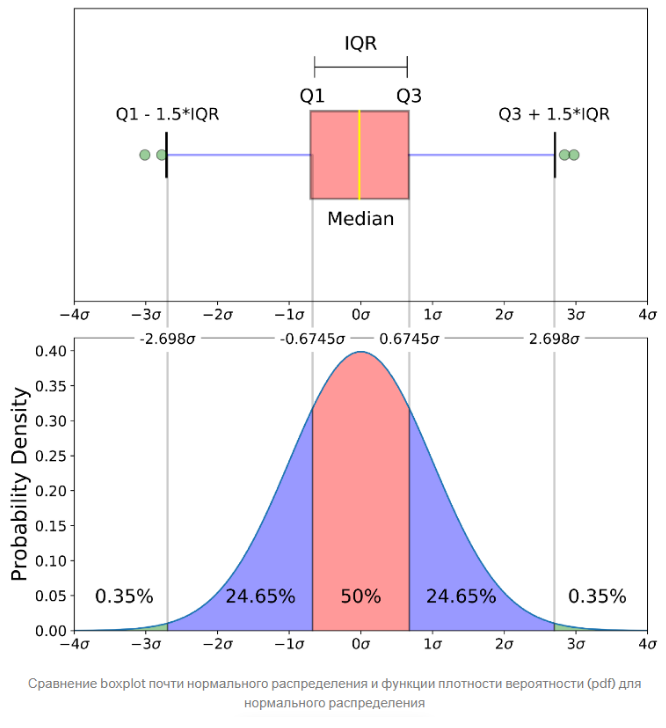

#### **Вывод**

На этапе исследовательского анализа данных была проделана работа и сделаны следующие выводы:

1. Посмотрели, сколько фильмов выходило в прокат каждый год. 
- наибольшее количество фильмов вышло в прокат в 2010 году - 985 фильмов 
- меньше всего фильмов вышло в 2017 году - 505 фильмов
- количество фильмов с показами в кинотеатрах значительно меньше общего количества фильмов, вышедших в прокат. Но наблюдается тренд роста с единственным просадком в 2017 году. 
 
2. Посчитали, какую долю составляют фильмы с указанной информацией о прокате в кинотеатрах и проанализировали, как эта доля менялась по годам. 
- доля фильмов с показами в кинотеатрах имеет устойчивый рост с 2010 года (11%) до 2017 года (71%), 
после чего показатель не опускается ниже 53%.

3. Изучили, как менялась динамика проката по годам
- начиная с 2014 по 2019 года наблюдается динамика роста кассовых сборов.
- максимальная сумма кассовых сборов была зафиксирована в 2018 году и составила - 49 668 403 134.32 рублей
- минимальная сумма кассовых сборов была зафиксирована в 2010 году и составила - 2 428 654.00 рублей
- данных о кассовых сборах за 2010 год очень мало, хотя фильмов в этом году вышло в прокат больше всего (см пункт 3.1).


4. С помощью сводной таблицы посчитали среднюю и медианную сумму сборов для каждого года.
- средняя по кассовым сборам гораздо больше, чем медиана. Видимо имеются фильмы с большими кассовыми сборами, 
что оказывает влияние на расчет средней.
- всплеск средних значений наблюдается в 2017 году

5. Определили влияние возрастных ограничений на сборы
- максимальные кассовые сборы наблюдаются у возрастной категории 16+
- фильмы с возрастным ограничением 0+ собрали минимальные сборы
- наименьшие кассовые сборы видны в возрастной категории 0+ в период с 2015 по 2019 года.
- самые высокие показатели по кассовым сборам наблюдаются у возрастной категории 16+ на протяжении заданного периода.
- к 2019 году показатели по всем возрастным ограничениям, кроме категории 0+, почти сравнялись. 


##  4. Исследование фильмов, которые получили государственную поддержку

### 4.1 Количество фильмов c господдержкой по годам

In [69]:
# Посмотрим основные статистические характеристики фильмов с господдержкой
non_zero_budget.describe()

,pu_number,refundable_support,nonrefundable_support,budget,ratings,box_office,show_start_year,support_rate
count,315.00,315.00,315.00,315.00,298.00,301.00,315.00,315.00
mean,"111,568,271.31","11,603,174.60","48,107,043.96","134,096,082.35",6.02,"130,698,257.71","2,016.74",0.52
std,"5,844,829.21","25,151,438.82","59,886,140.86","191,226,039.63",1.13,"339,190,287.30",1.65,0.17
min,"111,000,115.00",0.00,0.00,"14,462,464.00",1.00,"1,550.00","2,013.00",0.04
25%,"111,004,815.50",0.00,"25,000,000.00","46,153,866.50",5.40,"1,067,649.00","2,015.00",0.37
50%,"111,010,219.00",0.00,"30,000,000.00","73,379,554.00",6.20,"12,748,398.30","2,017.00",0.59
75%,"111,017,167.50","10,000,000.00","40,000,000.00","150,004,286.50",6.70,"103,134,751.12","2,018.00",0.66
max,"214,010,116.00","180,000,000.00","400,000,000.00","2,305,074,303.00",8.50,"3,073,568,690.79","2,019.00",0.78


In [70]:
# Посчитаем сколько фильмов выходило в прокат каждый год
support_counts = non_zero_budget.pivot_table(index= 'show_start_year', values= 'title', aggfunc='count').reset_index()
support_counts.columns = ['year', 'support_count']
display(support_counts)

,year,support_count
0,2013,2
1,2014,15
2,2015,80
3,2016,58
4,2017,39
5,2018,52
6,2019,69


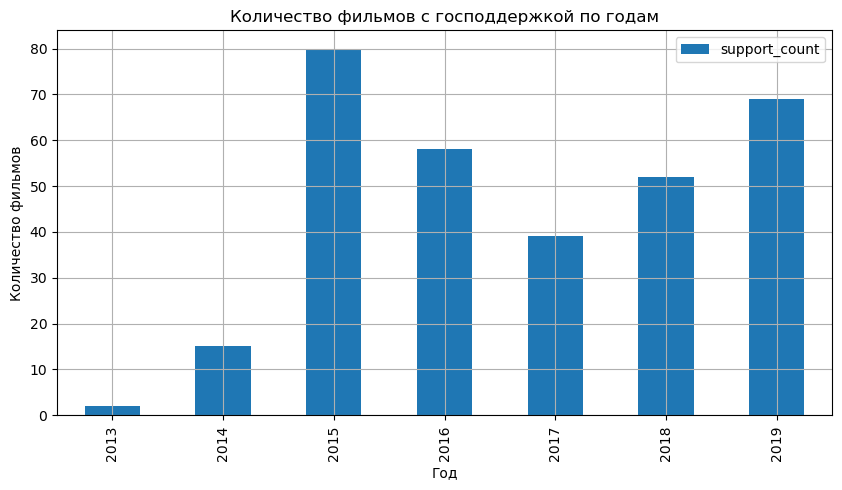

In [71]:
# Посмотрим график по годам для фильмов с государственной поддержкой
support_counts.plot(
    x='year', kind='bar', grid = True, figsize=(10, 5),
    title='Количество фильмов с господдержкой по годам', 
    xlabel='Год',
    ylabel='Количество фильмов')

plt.show()

- За период с 2013 по 2019 года вышло в прокат 315 фильмов с государственной поддержкой.
- Максимальное количество фильмов с государственной поддержкой было выпущено в прокат в 2015 году 
- Минимальное количество фильмов с государственной поддержкой наблюдается в 2013 году

### 4.2 Сколько выделяют средств на поддержку каждый год

In [72]:
# Создадим новый столбец с общей суммой государственной поддержки
non_zero_budget['support_total'] = non_zero_budget['refundable_support'] + non_zero_budget['nonrefundable_support']

# Посчитаем сумму государственной поддержки по годам
support_sum = non_zero_budget.pivot_table(index= 'show_start_year', values= 'support_total', aggfunc='sum').reset_index()
support_sum.columns = ['year', 'support_sum']
display(support_sum)

,year,support_sum
0,2013,"134,347,945.00"
1,2014,"549,002,299.00"
2,2015,"3,227,241,459.00"
3,2016,"3,977,155,482.00"
4,2017,"3,098,971,662.00"
5,2018,"3,098,000,000.00"
6,2019,"4,724,000,000.00"


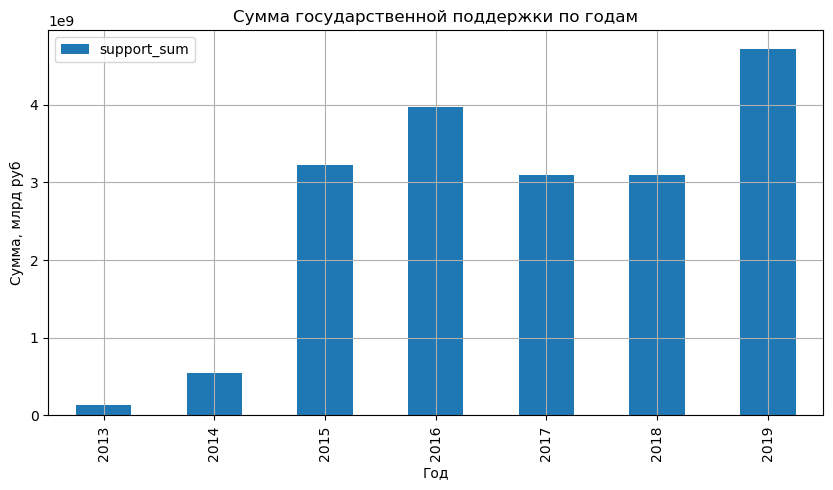

In [73]:
# Посмотрим график распределения суммы государственной поддержки по годам
support_sum.plot(
    x='year', kind='bar', grid = True, figsize=(10, 5),
    title='Сумма государственной поддержки по годам', 
    xlabel='Год',
    ylabel='Сумма, млрд руб')

plt.show()

- На графике видно, что за спериод с 2013 по 2016 года наблюдается увеличение государственной поддержки. 
- В 2017 и 2018 годах сумма госудасрственной поддержки немного уменьшилась по отношению к 2016.
- Максимальная сумма государственной поддержки фильмов наблюдается в 2019 году и составила 4,724,000,000.00 руб.
- Минимальная сумма государственной поддержки выделялась в 2013 году и составила 134,347,945.00 руб.


### 4.3 Окупаемость фильмов с госуподдержкой по годам (ROI)

In [74]:
# Создадим новый столбец с окупаемостью фильмов с государственной поддержкой
non_zero_budget['roi'] = ((non_zero_budget['box_office'] - non_zero_budget['budget']) / non_zero_budget['budget']) * 100

# Посчитаем среднюю и медиану окупаемости государственной поддержки по годам (ROI)
support_roi = non_zero_budget.pivot_table(index= 'show_start_year', values= 'roi', aggfunc=['mean', 'median']).reset_index()
support_roi.columns = ['year', 'roi_mean', 'roi_median']
display(support_roi)

,year,roi_mean,roi_median
0,2013,-94.10,-94.10
1,2014,-37.46,-94.51
2,2015,-52.17,-91.85
3,2016,-40.14,-86.57
4,2017,2.23,-61.75
5,2018,12.92,-66.98
6,2019,-12.20,-77.15


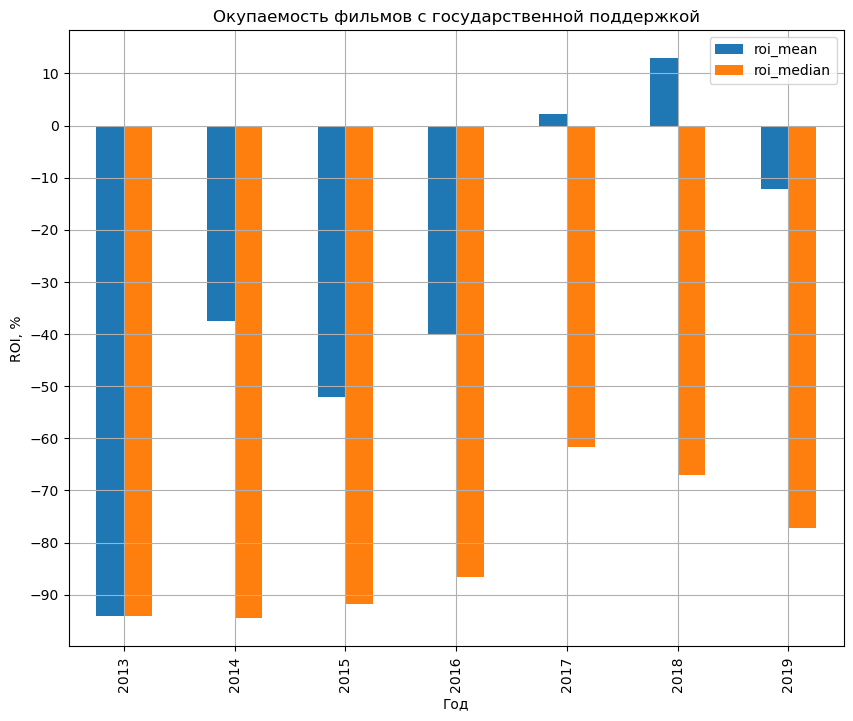

In [75]:
# Посмотрим график окупаемости государственной поддержки по годам
support_roi.plot(
    x='year', kind='bar', grid = True, figsize=(10, 8),
    title='Окупаемость фильмов с государственной поддержкой', 
    xlabel='Год',
    ylabel='ROI, %').yaxis.set_major_locator(MultipleLocator(base=10))

plt.show()

- Медианное значение окупаемости за период с 2013 по 2019 года показывает, что фильмы с государственной поддержкой убыточные.
- Среднее значение окупаемости за период с 2013 по 2016 года, а также за 2019 год, показывает что фильмы с государственной поддержкой не окупались. И только в 2017 и 2018 фильмы себя окупили
- Самым убыточным годом окупаемости оказался 2013 год. 

### 4.4 Рейтиг фильмов с господдержкой по годам

In [76]:
# Посмотрим рейтинг фильмов с господдержкой по годам - минимальное, максимальное и медианное значения
support_ratings = non_zero_budget.groupby('show_start_year')['ratings'].agg(['max', 'min', 'median']).reset_index()
support_ratings.columns = ['year', 'max', 'min', 'median']
support_ratings

,year,max,min,median
0,2013,8.10,5.30,6.70
1,2014,6.90,3.80,6.35
2,2015,8.50,2.80,6.20
3,2016,8.50,1.00,5.90
4,2017,8.00,2.90,6.20
5,2018,7.70,2.50,6.30
6,2019,8.20,3.20,6.15


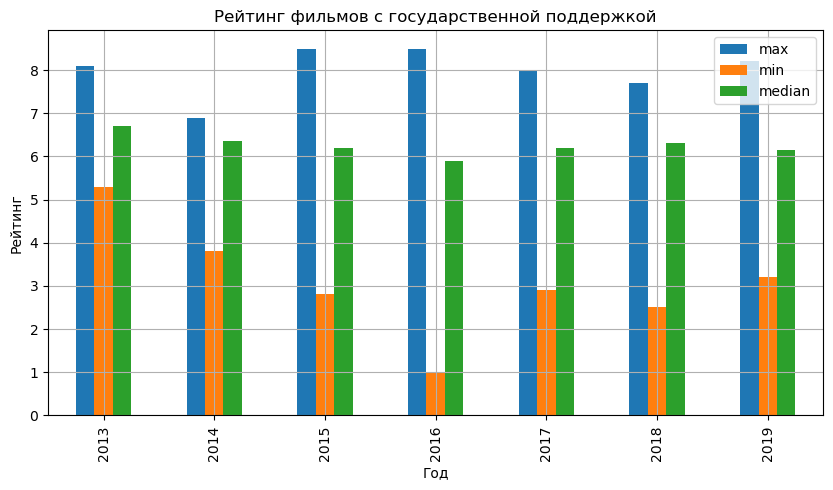

In [77]:
# Построим график рейтинга фильмов государственной поддержки по годам
support_ratings.plot(
    x='year', kind='bar', grid = True, figsize=(10, 5),
    title='Рейтинг фильмов с государственной поддержкой', 
    xlabel='Год',
    ylabel='Рейтинг')

plt.show()

- Если смотреть на медиану то видно, что в 2016 году были сняты фильмы и с максимальным и с минимальным рейтингом. 
- В остальные года медианное значение рейтинга особо не менялось, то есть рейтинг фильмов с государственной поддержкой не рос
- Из графика видно, что медианное значение рейтинга на протяжении всего рассматриваемого периода примерно одинаковый - около 6
- Также видно, что встречаются и фильмы с рейтингом выше 8, кроме 2018 года

### 4.5 Как менялась доля господдержки по годам

In [78]:
# Посмотрим как менялась доля господдержки по годам - минимальное, максимальное и медианное значения
support_rate = non_zero_budget.groupby('show_start_year')['support_rate'].agg(['max', 'min', 'median']).reset_index()
support_rate.columns = ['year', 'max', 'min', 'median']
support_rate

,year,max,min,median
0,2013,0.61,0.33,0.47
1,2014,0.70,0.22,0.54
2,2015,0.70,0.10,0.61
3,2016,0.78,0.07,0.64
4,2017,0.70,0.04,0.48
5,2018,0.70,0.16,0.56
6,2019,0.67,0.08,0.58


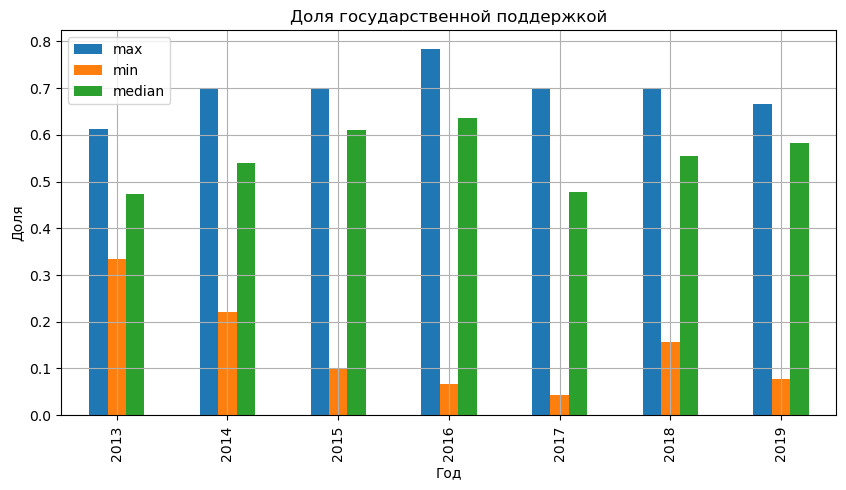

In [79]:
# Построим график доли государственной поддержки по годам
support_rate.plot(
    x='year', kind='bar', grid = True, figsize=(10, 5),
    title='Доля государственной поддержкой', 
    xlabel='Год',
    ylabel='Доля')

plt.show()

- Минимальное значение доли гос поддержки наблюдается в 2016 году
- Максимальное значение доли государственной поддержки наблюдается в 2016 году, медиана в этом году также достигает максимального значения

### 4.6 Топ 10 жанров с государственной поддержкой

In [80]:
non_zero_budget 

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,...,financing_source,ratings,genres,box_office,show_start_year,director_first,genres_first,support_rate,support_total,roi
1281,Пока еще жива,111005313,2013-10-11 12:00:00+00:00,Художественный,"АНО содействия развитию кинематографии ""Ангел-...",Россия,А.Атанесян,"А.Атанесян, М.Бабаханов, Р.Бутко",«16+» - для детей старше 16 лет,0.00,...,Министерство культуры,8.10,"драма,мелодрама","365,353.60",2013,А.Атанесян,драма,0.33,"26,500,000.00",-99.54
1448,Бесславные придурки,111003314,2014-03-28 12:00:00+00:00,Художественный,"ООО ""Компания ""АТК-Студио""",Россия,А.Якимчук,А.Тютрюмов,«12+» - для детей старше 12 лет,0.00,...,Министерство культуры,NaN,Unknown,"28,140.00",2014,А.Якимчук,Unknown,0.70,"26,000,000.00",-99.92
1498,Невидимки,111004213,2013-09-10 12:00:00+00:00,Художественный,"ООО ""Компания ""РЕАЛ-ДАКОТА""",Россия,"Р.Давлетьяров, С.Комаров","Р.Давлетьяров, А.Котелевский, А.Олейников",«12+» - для детей старше 12 лет,0.00,...,Фонд кино,5.30,"комедия,фантастика","19,957,031.50",2013,Р.Давлетьяров,комедия,0.61,"107,847,945.00",-88.66
1524,БЕРЦЫ,111004314,2014-05-05 12:00:00+00:00,Художественный,"ООО ""Студия ""Пассажир""",Россия,Е.Миндадзе (псевдоним Катя Шагалова),Л.Антонова,«16+» - для детей старше 16 лет,0.00,...,Министерство культуры,4.20,драма,"55,917.50",2014,Е.Миндадзе (псевдоним Катя Шагалова),драма,0.69,"28,000,000.00",-99.86
1792,Братья Ч,111004414,2014-04-23 12:00:00+00:00,Художественный,"ООО ""Студия ""Пассажир""",Россия,М.Угаров,"А.Миндадзе, Л.Антонова",«16+» - для детей старше 16 лет,0.00,...,Министерство культуры,6.40,драма,"232,100.00",2014,М.Угаров,драма,0.62,"25,000,000.00",-99.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7464,Союз спасения,111022019,2019-12-26 12:00:00+00:00,Художественный,"ЗАО ""Дирекция кино""",Россия,А.Кравчук,"А.Максимов, К.Эрнст",«12+» - для детей старше 12 лет,"100,000,000.00",...,Фонд кино,6.00,"история,биография,драма","717,703,185.53",2019,А.Кравчук,история,0.51,"500,000,000.00",-26.76
7466,Иван Царевич и Серый Волк 4,114005019,2019-12-20 12:00:00+00:00,Анимационный,"ООО ""Студия анимационного кино ""Мельница""",Россия,"Д.Шмидт, К.Феоктистов","С.Сельянов, А.Боярский",«6+» - для детей старше 6 лет,"100,000,000.00",...,Фонд кино,6.70,"мультфильм,приключения,семейный","501,069,235.00",2019,Д.Шмидт,мультфильм,0.53,"100,000,000.00",163.72
7474,Вторжение,111022519,2019-12-23 12:00:00+00:00,Художественный,"ООО ""Арт Пикчерс Студия"", ООО ""Водород 2011""",Россия,Ф.Бондарчук,"Ф.Бондарчук, М.Врубель, А.Андрющенко, Д.Рудовский",«12+» - для детей старше 12 лет,"100,000,000.00",...,Фонд кино,5.70,"фантастика,боевик",NaN,2019,Ф.Бондарчук,фантастика,0.53,"500,000,000.00",NaN
7476,Я свободен,111023019,2019-12-26 12:00:00+00:00,Художественный,"АО ""ТПО ""Киностудия им. М.Горького""",Россия,И.Северов,С.Зернов,«12+» - для детей старше 12 лет,0.00,...,Министерство культуры,5.90,драма,NaN,2019,И.Северов,драма,0.65,"30,000,000.00",NaN


In [81]:
# Посмотрим 10 уникальных значений столбца  основного жанра
non_zero_budget['genres_first'].value_counts().head(10)

genres_first
драма         92
комедия       68
мультфильм    26
Unknown       15
триллер       14
мелодрама     14
фэнтези       11
ужасы         10
фантастика    10
военный        9
Name: count, dtype: int64

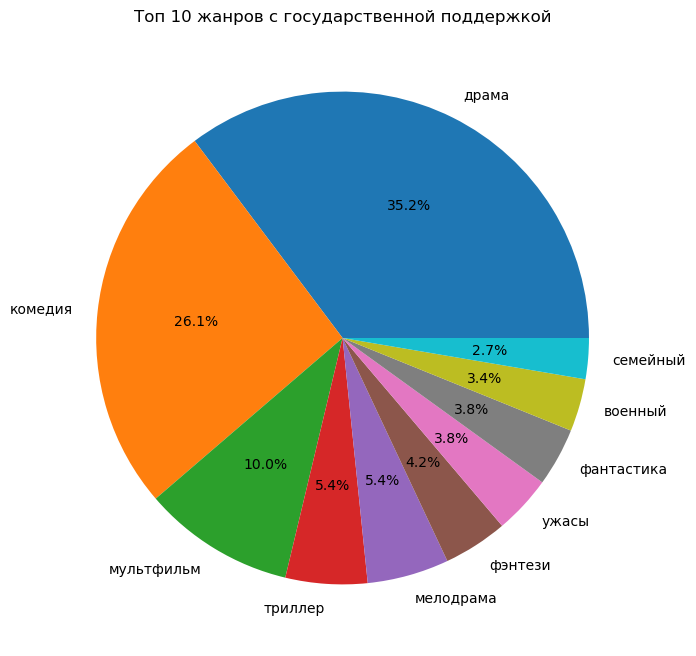

In [82]:
# Топ 10 жанров, наиболее привлекательных для выделения господдержки за весь рассматриваемый период
non_zero_budget.loc[non_zero_budget['genres_first'] != 'Unknown', 'genres_first'].value_counts().head(10).plot.pie(
    figsize=(8, 8), autopct='%1.1f%%')
plt.title('Топ 10 жанров с государственной поддержкой')
plt.ylabel('')
plt.show()

- Самым популярным жанром для фильмов с государсвтенной поддержкой оказалась драма.
- Замыкает список топ 10 жанров - военные фильмы 

### 4.7 Зависимости между показателями

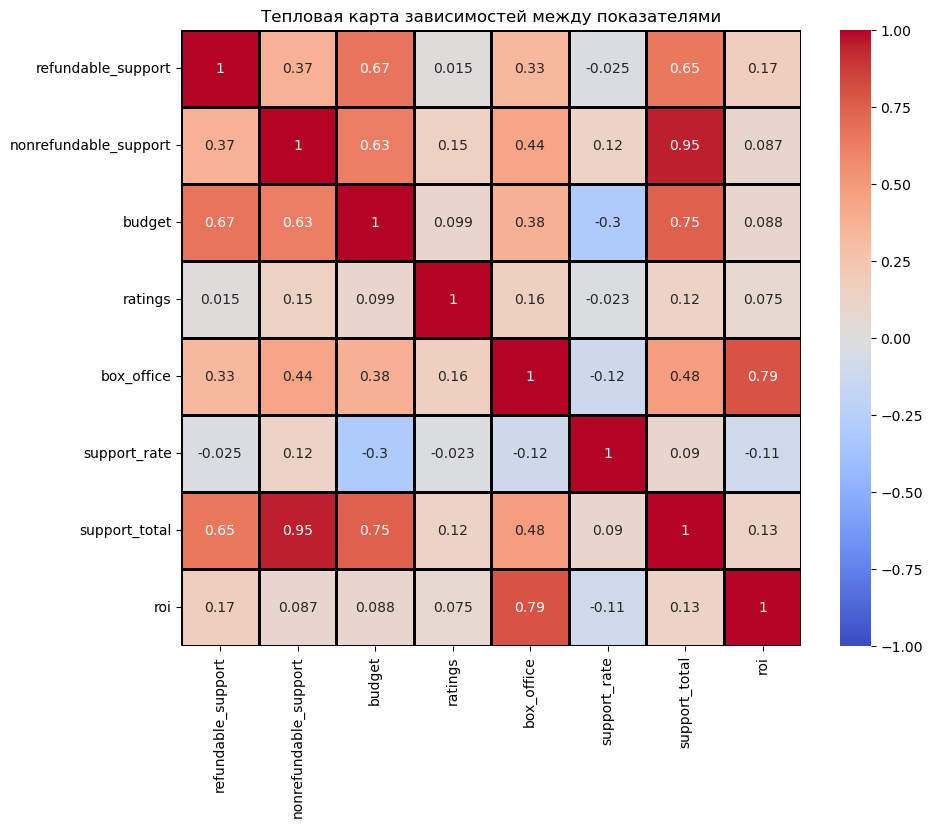

In [83]:
# Построим тепловую карту зависимостей между показателями
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    non_zero_budget.loc[:, ['refundable_support', 'nonrefundable_support', 'budget', 
                            'ratings', 'box_office', 'support_rate', 'support_total', 'roi']].corr(), 
    annot = True, vmin=-1, vmax=1,
    center= 0, cmap= 'coolwarm', linewidths=1, linecolor='black',
)
plt.title('Тепловая карта зависимостей между показателями')
plt.show()

- По тепловой карте наблюдаются только очевидные взаимосвязи. Например, зависимость между объёмом возвратных и невозвратных средств государственной поддержки.
- Сумма государственной поддержки не особо оказывает влияние на рейтинг фильмов, об этом говорит коэффициент корреляции - 0,12

#### **Вывод**

На этапе исследования фильмов, которые получили государственную поддержку, мы проделали следующую работу:

1. Посмотрели сколько фильмов c государственной поддержкой выходило в прокат каждый год
- за период с 2013 по 2019 года вышло в прокат 315 фильмов с государственной поддержкой.
- максимальное количество фильмов с государственной поддержкой было выпущено в прокат в 2015 году 
- минимальное количество фильмов с государственной поддержкой наблюдается в 2013 году

2. Посчитали сколько выделяют средств на поддержку каждый год
- за спериод с 2013 по 2016 года наблюдается увеличение государственной поддержки.
- максимальная сумма государственной поддержки фильмов наблюдается в 2019 году и составила 4,724,000,000.00 руб.
- минимальная сумма государственной поддержки выделялась в 2013 году и составила 134,347,945.00 руб.

3. Посчитали окупаемость фильмов с госуподдержкой по годам (ROI)
- медианное значение окупаемости за период с 2013 по 2019 года показывает, что фильмы с государственной поддержкой убыточные.
- среднее значение окупаемости за период с 2013 по 2016 года, а также за 2019 год, показывает что фильмы с государственной поддержкой не окупались. И только в 2017 и 2018 фильмы себя окупили
- самым убыточным годом окупаемости оказался 2013 год.

4. Изулили рейтиг фильмов с господдержкой по годам
- в 2016 году были сняты фильмы и с максимальным и с минимальным рейтингом.
- в остальные года медианное значение рейтинга особо не менялось, то есть рейтинг фильмов с государственной поддержкой не рос
- также видно, что встречаются и фильмы с рейтингом выше 8, кроме 2018 года

5. Как менялась доля господдержки по годам
- минимальное значение доли гос поддержки наблюдается в 2016 году
- максимальное значение доли государственной поддержки наблюдается в 2016 году, медиана в этом году также достигает максимального значения

6. Топ 10 жанров с государственной поддержкой
- самым популярным жанром для фильмов с государсвтенной поддержкой оказалась драма.
- замыкает список топ 10 жанров - военные фильмы


## Общий вывод

Нам был предоставлен доступ к датасету, который содержит данные о прокатных удостоверениях, сборах и государственной поддержке фильмов, а также информацию с сайта КиноПоиск. 
В результате исследования данного датасета были изучены основные статистические показатели, заполнены пропуски, удалены дубликаты.

По результатам исследования были изучены нижеперечисленные вопросы и сделаны следующие выводы:

1. **Сколько фильмов выходило в прокат каждый год**
- Наибольшее количество фильмов вышло в прокат в 2010 году - 985 фильмов. 
- Меньше всего фильмов вышло в 2017 году - 505 фильмов.
- Количество фильмов с показами в кинотеатрах значительно меньше общего количества фильмов, вышедших в прокат. 
- Наблюдается тренд роста с единственным просадком в 2017 году. 

2. **Доля фильмов с показами в кинотеатрах**
- Доля фильмов с показами в кинотеатрах имеет устойчивый рост с 2010 года (11%) до 2017 года (71%), после чего показатель не опускается ниже 53%.

3. **Сумма сборов по годам**
- Начиная с 2014 по 2019 года наблюдается динамика роста кассовых сборов. 
- Максимальная сумма кассовых сборов была зафиксирована в 2018 году и составила - 49,7 млрд рублей
- Минимальная сумма кассовых сборов была зафиксирована в 2010 году и составила - 2,4 млн рублей
- Данных о кассовых сборах за 2010 год очень мало, хотя фильмов в этом году вышло в прокат больше всего.
- Средние значения по кассовым сборам гораздо выше, чем медиана. Видимо имеются фильмы с большими кассовыми сборами, что оказывает влияние на расчет средней.
- Всплеск средних значений наблюдается в 2017 году.

4. **Влияние возрастных ограничений на сборы**
- Максимальные кассовые сборы наблюдаются у возрастной категории 16+
- Фильмы с возрастным ограничением 0+ собрали минимальные сборы
- Наименьшие кассовые сборы видны в возрастной категории 0+ в период с 2015 по 2019 года.
- Самые высокие показатели по кассовым сборам наблюдаются у возрастной категории 16+ на протяжении всего рассматриваемого периода.
- К 2019 году показатели по всем возрастным категориям, кроме категории 0+, практически сравниваются.

5. **Фильмы с государственной поддержкой**
- За период с 2013 по 2019 года вышло в прокат 315 фильмов с государственной поддержкой.
- Максимальное количество фильмов с государственной поддержкой было выпущено в прокат в 2015 году 
- Минимальное количество фильмов с государственной поддержкой наблюдается в 2013 году
- За спериод с 2013 по 2016 года наблюдается увеличение государственной поддержки. 
- Максимальная сумма государственной поддержки фильмов наблюдается в 2019 году и составила 4,7 млрд руб.
- Минимальная сумма государственной поддержки выделялась в 2013 году и составила 134,3 млн руб.
- Медианное значение окупаемости за период с 2013 по 2019 года показывает, что фильмы с государственной поддержкой убыточные.
- Среднее значение окупаемости за период с 2013 по 2016 года, а также за 2019 год, показывает что фильмы с государственной поддержкой не окупались. И только в 2017 и 2018 фильмы себя окупили
- Самым убыточным оказался 2013 год. 
- В 2016 году были сняты фильмы и с максимальным и с минимальным рейтингом, с государственной поддержкой. 
- В остальные года медианное значение рейтинга особо не менялось, то есть рейтинг фильмов с государственной поддержкой не рос
- Минимальное значение доли господдержки наблюдается в 2016 году
- Максимальное значение доли государственной поддержки наблюдается в 2016 году, медиана в этом году также достигает максимального значения
- Самым популярным жанром для фильмов с государсвтенной поддержкой оказалась драма.
- Замыккает список топ 10 жанров - военные фильмы 
- По тепловой карте наблюдаются только очевидные взаимосвязи. Например, зависимость между объёмом возвратных и невозвратных средств государственной поддержки.
- Сумма государственной поддержки не особо оказывает влияние на рейтинг фильмов, об этом говорит коэффициент корреляции - 0,12
